In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [3]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [4]:
from src.nettack.GCN import *
from src.nettack.utils import *
from src.nettack.nettack import *

In [5]:
# UTILS
def sparse_numpy2sparse_torch(x):
    x = x.tocoo()
    values = x.data
    indices = np.vstack((x.row, x.col)).astype(float)
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = x.shape
    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

# Classification

In [116]:
class Evaluater:
    
    def __init__(self):
        pass
    
    def load_dataset(self, path):
        _A_obs, _X_obs, _z_obs = load_npz(path)
        # Normalizing Adjacency matrix
        _A_obs = _A_obs + _A_obs.T
        _A_obs[_A_obs > 1] = 1
        # For the algorithm to work, we have to consider a connected graph.
        lcc = largest_connected_components(_A_obs)
        _A_obs = _A_obs[lcc][:,lcc]
        _X_obs = _X_obs[lcc].astype('float32')
        _z_obs = _z_obs[lcc]
                
        assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
        assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
        assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"
        
        self._A_obs = _A_obs
        self._X_obs = _X_obs
        self.A = sparse_numpy2sparse_torch(_A_obs)
        self.X = sparse_numpy2sparse_torch(_X_obs)
        self.N = _A_obs.shape[0]
        self.K = _z_obs.max()+1
        self.Z = _z_obs
        self.Ztorch = torch.tensor(_z_obs.astype(np.int64))
        # Normalizing adjacency matrix
        self.An = sparse_numpy2sparse_torch(preprocess_graph(_A_obs))
        self.degrees = _A_obs.sum(0).A1
        
    def create_splits(self):
        
        unlabeled_share = 0.8
        val_share = 0.1
        train_share = 1 - unlabeled_share - val_share
        splits = train_val_test_split_tabular(np.arange(self.N), train_size=train_share,
                                              val_size=val_share, test_size=unlabeled_share,
                                              stratify=self.Z)
        split_train, split_val, split_unlabeled = splits
        self.split_train = np.array(split_train).astype(np.int64)
        self.split_val = np.array(split_val).astype(np.int64)
        self.split_unlabeled = np.array(split_unlabeled).astype(np.int64)

        print(f'Number of training node : {len(split_train)}')
        print(f'Number of validation nodes : {len(split_val)}')
        print(f'Number of unlabeled (unknown) nodes : {len(split_unlabeled)}')
        
    def train_model(self, surrogate=False, with_perturb=False):
        sizes = [16, self.K]
        name = "surrogate" if surrogate else ("pertubed" if with_perturb else "clean")
        A = sparse_numpy2sparse_torch(self.nettack.adj_preprocessed) if (with_perturb and not surrogate) else self.An
        X = sparse_numpy2sparse_torch(self.nettack.X_obs) if (with_perturb and not surrogate) else self.X
        self.nn = GCN(sizes, A, X, with_relu=(not surrogate), name=name)
        self.model = GCN_Model(self.nn, lr=1e-2)
        self.model.train(self.split_train, self.split_val, self.Ztorch, print_info=False)
        self.logits = self.model.logit_nodes.detach().cpu().numpy()
        self.preds = self.logits.argmax(axis=1)
        truth = self.Z[self.split_val]
        print(f'Accuracy : {(truth == self.preds).mean()}')
        self.W1 = self.model.gcn.gc1.weight
        self.W2 = self.model.gcn.gc2.weight
        self.probas = np.exp(self.logits) / np.exp(self.logits).sum(1)[:, None]
        probas_surr_sorted = np.argsort(-self.probas, axis=1)
        second_l = (probas_surr_sorted == self.Z[self.split_val][:, None]).argmin(axis=1)
        self.margins = (self.probas[np.arange(len(self.split_val)), self.Z[self.split_val]] -
                       self.probas[np.arange(len(self.split_val)), second_l])
        
    def attack(self, u, verbose=False, n_perturbations=None, direct_attack=True,
               perturb_features=True, perturb_structure=True):
        self.nettack = Nettack(self._A_obs, self._X_obs, self.Z, self.W1, self.W2, u, verbose=verbose)
        self.nettack.reset()
        if n_perturbations is None:
            n_perturbations = int(self.degrees[u])
        n_influencers = 1 if direct_attack else 5
        self.nettack.attack_surrogate(n_perturbations,
                         perturb_structure=perturb_structure,
                         perturb_features=perturb_features,
                         direct=direct_attack,
                         n_influencers=n_influencers)

In [113]:
Ev = Evaluater()
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()
Ev.train_model(surrogate=True)

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 15 iterations
Accuracy of surrogate : 0.8313253012048193


In [114]:
Ev.attack(0, verbose=True)

##### Starting attack #####
##### Attack node with ID 0 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [   0 1785]
##### ...2/5 perturbations ... #####
Edge perturbation: [   0 1977]
##### ...3/5 perturbations ... #####
Edge perturbation: [   0 1422]
##### ...4/5 perturbations ... #####
Edge perturbation: [   0 2081]
##### ...5/5 perturbations ... #####
Edge perturbation: [   0 1084]


In [115]:
Ev.train_model(surrogate=False, with_perturb=False)

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 19 iterations
Accuracy of surrogate : 0.8353413654618473


In [119]:
clean_margins = Ev.margins

In [120]:
Ev.train_model(surrogate=False, with_perturb=True)

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 54 iterations
Accuracy of surrogate : 0.8594377510040161


In [121]:
attacked_margins = Ev.margins

<IPython.core.display.Javascript object>


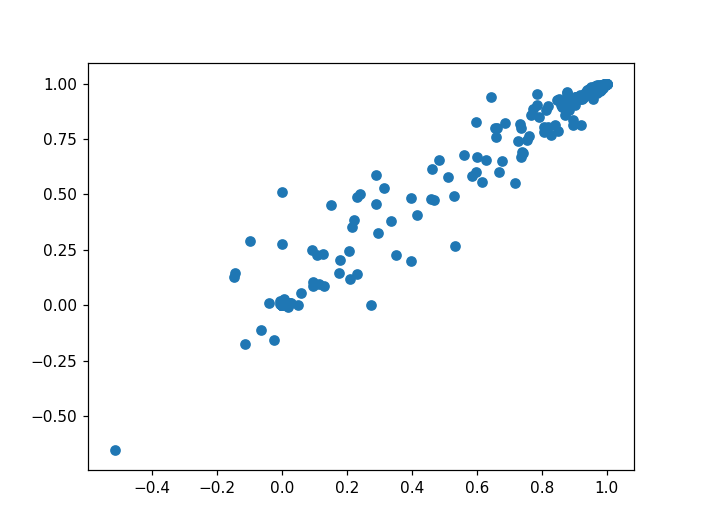

In [124]:
plt.scatter(clean_margins, attacked_margins)